# Backwards Features Elimination using SHAP and CV

Backwards Features Elimination allows to efficiently reduce the number of features in your dataset, without losing the predictive power of the model. `Probatus` implements the following features elimination routine for **tree-based models**:

```
While any features left, iterate:
    1. Optimize hyperparameters and fit a model for a given features set. 
        You can either use GridSearchCV of RandomSearchCV from sklearn.
    2. Remove n lowest SHAP importance features
```

The main advantages of using this routine are:
- High computation speed compared to recursive algorithms.
- Uses SHAP importance, which is one of the most reliable ways to estimate features importance. Unlike many other techniques, it works with missing values and categorical variables.
- Uses Cross-validation to optimize hyperparameters for each features set. This way you can assess if removal of a given feature reduces the predictive power, or simply requires additional tuning of the model.

The disadvantages are:
- One needs to manually select how many features to keep at the end of the routine, based on how the performance of the model changes between rounds.
- Removing lowest SHAP importance feature does not always translate to choosing the feature with lowest impact on model's performance.
- The current implementation works with tree-based models only, due to much lower speed of SHAP importance computation for other types of models.

## Setup the dataset

In order to use the functionality, let's set up an example dataset with:
- numerical features
- 1 categorical feature
- 1 static feature
- 1 feature with missing values

`Probatus` can handle such dataset if you use an appropriate binary model that handles the above issues in the data e.g. LightGBM.

In [1]:
from probatus.features_elimination import ShapBFE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import lightgbm
 
feature_names = ['f1_categorical', 'f2_missing', 'f3_static', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']
 
# Prepare two samples
X, y = make_classification(n_samples=1000, class_sep=0.05, n_informative=6, n_features=20,
                           random_state=0, n_redundant=10, n_clusters_per_class=1)
X = pd.DataFrame(X, columns=feature_names)
X['f1_categorical'] = X['f1_categorical'].apply(lambda x: str(np.round(x*10)))
X['f2_missing'] = X['f2_missing'].apply(lambda x: x if np.random.rand()<0.8 else np.nan)
X['f3_static'] = 0

In [2]:
X.head()

,f1_categorical,f2_missing,f3_static,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
0,34.0,-3.902230,0,0.037207,-0.211075,2.378358,0.474059,-0.580471,2.523367,1.265063,-0.698129,0.320310,0.373186,1.828942,-3.116881,-0.960251,-0.031511,-1.294803,0.115819,-2.727467
1,-25.0,0.772855,0,0.302824,0.729950,0.815054,1.157228,1.347449,-1.880812,0.222902,2.293246,0.286349,0.063909,0.036967,-1.016085,0.035576,-0.439491,0.823261,2.284586,0.674484
2,-7.0,1.350847,0,1.837895,-0.745689,0.327826,0.755258,1.499059,-1.987181,0.093551,0.734911,0.579087,0.216668,-1.523017,-1.940202,0.763642,-0.764415,1.879374,1.239255,0.767797
3,-53.0,4.559465,0,-1.277930,3.688404,-2.369522,0.927847,-0.155483,-2.434361,0.448693,2.021587,-0.609161,-1.699683,-2.938755,1.995516,-2.558037,-1.103081,3.084860,6.632615,0.754824
4,-10.0,1.505766,0,-0.576209,-0.790525,-0.585126,-0.499129,1.324540,-0.077793,0.352424,-1.728604,0.987153,-0.754924,0.257670,1.381853,1.751669,-1.043428,-0.848575,-3.581535,2.810744


In [3]:
X.dtypes.head()

f1_categorical     object
f2_missing        float64
f3_static           int64
f4                float64
f5                float64
dtype: object

## Set up the model and it's optimization space

You need to set up the model and it's hyperparameter optimization space/grid for the Backwards Features Elimination. `Probatus` requires a **tree-based binary classifier** in order to speed up the computation of SHAP feature importance at each step. 

We recommend using LGBMClassifier, which by default handles missing values and categorical features.

In [4]:
clf = lightgbm.LGBMClassifier(max_depth=5, class_weight='balanced')

param_grid = {
    'n_estimators': [5, 7, 10],
    'num_leaves': [3, 5, 7],
}

## Apply ShapBFE

The ShapBFE class in `probatus` implements the Backwards Features Elimination, in which, at each step the Cross-Validation based hyperparameter optimization is performed, and the lowest SHAP importance features are removed.

In [5]:
shap_elimination = ShapBFE(
    clf=clf, search_space=param_grid, search_schema='grid', 
    n_removed_per_iter=0.2, cv=20, scoring='roc_auc', n_jobs=3)
report = shap_elimination.fit_compute(X, y)

Removing static features ['f3_static'].
The following variables contain missing values ['f2_missing']. Make sure to imputemissing or apply a model that handles them automatically.
Changing dtype of ['f1_categorical'] from "object" to "category". Treating it as categorical variable. Make sure that the model handles categorical variables, or encode them first.


Round: 1, Current number of features: 19, Current performance: Train 0.942 +/- 0.008, CV Validation 0.887 +/- 0.033. 
Removed features at the end of the round: ['f7', 'f6', 'f17', 'f4'], Num of features left: 15.
Round: 2, Current number of features: 15, Current performance: Train 0.942 +/- 0.008, CV Validation 0.886 +/- 0.032. 
Removed features at the end of the round: ['f13', 'f10', 'f2_missing'], Num of features left: 12.
Round: 3, Current number of features: 12, Current performance: Train 0.942 +/- 0.008, CV Validation 0.884 +/- 0.04. 
Removed features at the end of the round: ['f12', 'f20', 'f18'], Num of features left: 9.
Round: 4, Current number of features: 9, Current performance: Train 0.938 +/- 0.006, CV Validation 0.884 +/- 0.042. 
Removed features at the end of the round: ['f8', 'f11'], Num of features left: 7.
Round: 5, Current number of features: 7, Current performance: Train 0.929 +/- 0.005, CV Validation 0.875 +/- 0.043. 
Removed features at the end of the round: ['f14'

At the end of the process, you can investigate the results for each iteration.

In [6]:
report.head()

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std,param_n_estimators,param_num_leaves
1,19,"[f1_categorical, f2_missing, f4, f5, f6, f7, f...","[f7, f6, f17, f4]",0.942,0.008,0.887,0.033,10,7
2,15,"[f5, f13, f16, f9, f10, f18, f11, f19, f12, f1...","[f13, f10, f2_missing]",0.942,0.008,0.886,0.032,10,7
3,12,"[f16, f5, f9, f18, f11, f19, f12, f1_categoric...","[f12, f20, f18]",0.942,0.008,0.884,0.040,10,7
4,9,"[f16, f5, f9, f11, f19, f1_categorical, f8, f1...","[f8, f11]",0.938,0.006,0.884,0.042,10,7
5,7,"[f16, f5, f9, f19, f1_categorical, f15, f14]","[f14, f5]",0.929,0.005,0.875,0.043,10,7


Once the process is completed, you can visualize the results. 

Let's investigate the performance plot. Clearly, the Validation score starts decreasing between 9 and 7 features, and has a sharp drop between 3 and 2 features only. Therefore, you can safely remove 11 out of 20 features without loss of performance, or discard 17 out of 20 in order to keep only the essential ones.

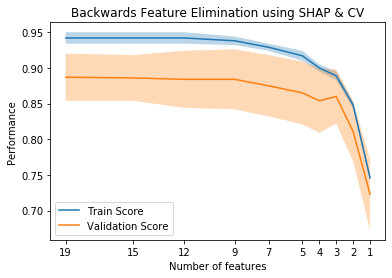

In [7]:
performance_plot = shap_elimination.plot()

The final features set for 9 features would be the following:

In [10]:
shap_elimination.get_reduced_features_set(num_features=9)

['f16', 'f5', 'f9', 'f11', 'f19', 'f1_categorical', 'f8', 'f15', 'f14']

Now let's visualize how the optimal hyperparameter's values are affected by the features elimination.

For both parameters `n_estimators` and `num_leaves`, the optimal values for most of the rounds are equal to the maximum values of these parameters in the search grid. This indicates that you can possibly further improve the results by increasing the search ranges for these parameters. However, it is crucial to ensure that the model does not overfit. Currently, there is a visible gap between Train and Validation scores for features sets having more than 3 features, therefore, one should also consider further regularizing the model.

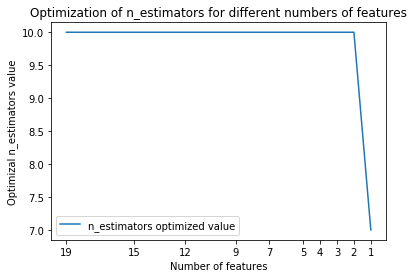

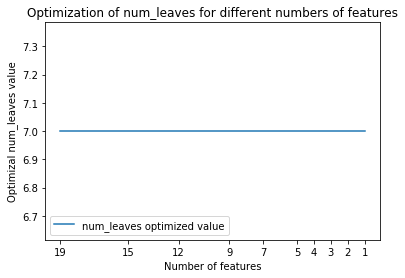

In [11]:
param_plots = shap_elimination.plot('parameter', param_names=['n_estimators', 'num_leaves'])